# DSC 180: Assignment 3
### *Tommy Evans-Barton*

## Introduction and Historical Background

Ever since the arrival of the automobile as a part of everyday life, law enforcement has been tasked with regulating public health and safety when it comes to the road. As more cars crowded the road, traffic intersections were designed to limit collisions. As the danger to pedestrians became more clear, with several deaths occurring due to collisions with oncoming vehicles, crosswalks and walkways were created. As more people drove vehicles, the laws of the road were put into place, and it became the police force's job to ensure that these rules were obeyed for the greater safety of the general public.

However, from the beginning there were issues with the methods of this enforcement; in fact, the very first recorded instance of one of these issue was all the way back in 1916, with the case of Captain John Bates, where, while attempting to stop and question the Captain, three police officers murdered Bates' wife while attempting to shoot out the vehicle's tires (Sarah Seo). Yes, issues with law enforcement on the road stem all the way back to the very inception of the automobile, and they have only continued since then, as court cases such as *Whren vs. United States* (in which the court ruled that police officers could subjectively pick and choose to pull drivers over based on a profile, while not having to be concerned with equity of the enforcement of traffic laws) and *Terry vs. Ohio* (which gave officers the right to search an individual at a traffic stop, no matter the original reason for the stop) have distorted the law's original intention in order to put more power into the hands of officers on the road.

Fast forward to today, and many have begun questioning with growing force the legality and fairness of police officers' traffic stops, specifically when it comes to their perceived inequality with regards to race. While many police districts and precincts will claim that they do not profile based on race alone, and that their officers go under specific training to combat racism, it seems that every month a new video surfaces of an African American or Hispanic driver being harassed and abused during what would normally be a routine traffic stop. While some may argue that these are merely isolated instances, many more have claimed that these are merely indicative of a systemic issue with the way that the laws of the road have and are being applied.

It is very difficult to get to the bottom of whether or not (and to what extend) racism is present in these stops. Sure one race may get pulled over more, but does that alone imply unfair practices? Or, as some have argued, does that merely indicate that that race is more likely to drive illegally? Or have a vehicle that doesn't meet code? Or live in a neighborhood where stops are conducted more often? All of these and more are confounding variables that are very difficult to control for in an everyday, real-world setting. However, with the stops data provided by the city of San Diego, and the *Veil of Darkness* technique originally performed by researchers at San Diego State University, it may be possible to get to the bottom of this question.

In [15]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import json
import sys
import matplotlib.pyplot as plt
import requests
import scipy.stats

In [16]:
sys.path.append('../')
sys.path.append('../src/data')
sys.path.append('../src/processing')
sys.path.append('../src/visualization')

In [17]:
from etl import get_data
import cleaning
import visualize
import calculations

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%matplotlib inline

## Data

As said above, our data consists of stops within the city of San Diego. This data is mandated to be recorded by the officer that pulls over the offending party; at every stop, they are required to fill out a form with information such as the reason for the stop, what occurred during the stop, various information regarding the person/people in the vehicle, and other details. 

### Two Notes

**Note 1**: As of 2018, there are slightly different formats than the years 2014-2017, as the law made various changes in this process in an attempt to improve the quality of the data. 

**Note 2**: I will mostly be working with the 2015 data, as it is fairly indicative of the rest of the data, and this is the same approach that the SDSU group decided to take. Briefly, I will also discuss the 2018-2019 data, as it does differ in several ways from the previous years.

In [6]:
file_path = '../config/data-params.json'
cfg = json.load(open(file_path))

In [24]:
get_data(**cfg)

In [7]:
df2015 = pd.read_csv('../data/raw/2015.csv')
df2018_2019 = pd.read_csv('../data/raw/2018-2019.csv')[['stop_id', 'reason_for_stop', 'beat', 'race', 'perceived_gender', 'perceived_age', 
                          'date_stop', 'time_stop', 'result', 'basis_for_search', 'action', 'consented', 
                          'contraband', 'type_of_property_seized']]

## Assessing the Validity of the Data and EDA

Before diving wholeheartedly into the analysis of this data, it is important to assess both its completeness as well as its validity, so that the decisions we make when working with the data have some much needed context.

### Missingness
One way that data often has issues is when it is missing values for important information, that would make analysis on said data impossible.

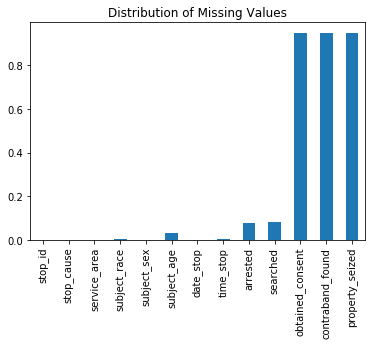

In [9]:
visualize.null_plot(df2015)

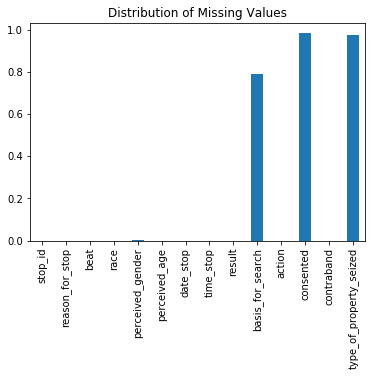

In [10]:
visualize.null_plot(df2018_2019)

Within these graphs it is evident that there are many missing values for entries in the consent, contraband, and property seized columns, for 2015, as well as the basis for search column for 2018. However these omissions are more than likely a non-issue, as while these lack of entries may at first appear troubling, for features such as these, a lack of an entry most likely indicates that a search was not even conducted, which is how we will treat these when cleaning our dataset (this type of missing value is often called missing by design).

### Accuracy
Another issue often had within features of a dataset are their accuracy, as input errors and other such problems can skew data analysis conclusions.
#### Stop Cause

In [10]:
df2015.stop_cause.value_counts()

Moving Violation                      86397
Equipment Violation                   27460
Radio Call/Citizen Contact              497
Muni, County, H&S Code                  348
Personal Knowledge/Informant            251
No Cause Specified on a Card            195
Suspect Info (I.S., Bulletin, Log)      159
MUNI, County, H&S Code                   15
Personal Observ/Knowledge                12
Other                                     7
none listed                               6
not marked                                4
UNI, &County, H&&S Code                   3
&Moving Violation                         3
not noted                                 2
NOT MARKED                                2
Suspect Info                              2
NOTHING MARKED                            2
NOT SPECIFIED                             2
not listed                                1
not secified                              1
CAUSE NOT LISTED ACTION NOT LISTED        1
not marked  not marked          

As seen above, there are clearly accuracy issues with `stop_cause` in the dataset, as there are several stop causes that don't seem to have any rational sense to them, or that are irrelevant to our investivation e.g.:

    - wm23
    - f25
    - Pedestrian
    
which we will have to remove, as well as many different versions of `Null` that do not appear in our initial scan of incomplete entries:
    
    - No Cause Specified on a Card
    - none listed
    - not marked
    - not noted
    - NOT SPECIFIED
    - NOTHING MARKED
    - NOT MARKED
    - not marked  not marked
    - not listed
    - not secified
    - none noted
    - NOT CHECKED
    - CAUSE NOT LISTED ACTION NOT LISTED
    - Other

, which we will also have to remove. All told, these values account for 229 entries (.2%) of the data in 2015, meaning that they can most likely be ignored without issue, as this is not a significant portion of the entries for this data.

#### Subject Age

In [11]:
df2015.subject_age.unique()

array([nan, '26', '40', '37', '29', '23', '24', '31', '60', '54', '42',
       '50', '30', '22', '41', '27', '48', '20', '28', '34', '44', '21',
       '49', '25', '58', '45', '59', '66', '64', '47', '32', '63', '52',
       '57', '70', '35', '19', '68', '55', '62', '65', '53', '46', '38',
       '75', '43', '74', '97', '79', '72', '16', '76', '39', '18', '17',
       '61', '56', '51', '36', '33', '77', '73', '83', '5', '71', '67',
       '69', '81', '78', '90', '213', '80', '222', '84', '88', '85', '0',
       '4', '82', '99', '91', '89', '6', '87', '7', '15', '86', '1', '2_',
       '93', '3', '8', '4_', 'No Age', '1020', 'y', '223', 'f', '345',
       'h', '125', '3.7', 'j', '3_', '243', '224', '399', 'f26', '32`',
       '13', '14', '9', '11', 'x', '92', '55Q', 'F48', '456', '2005', '`',
       '233', '96', '701', '387', '180', 'f28', 'Y', 'NN', '10', '173',
       '2', '98', '94', '100'], dtype=object)

In [12]:
df2018_2019.perceived_age.unique()

array([ 25,  30,  23,  22,  37,  28,  50,  60,  35,  20,  40,  62,  42,
        45,  24,  27,  14,  48,  21,  55,  26,  59,  53,  43,  70,  19,
        52,  33,  63,  18,  32,  29,  38,  31,  76,  65,  54,  56,  67,
        47,  69,  58,  16,  36,  79,  68,  57,  17,  75,  44,   9,  51,
        41,  49,  80,  90,  64,  34,  15,  10,  46,  39,  66,  61,   5,
        72,  85,  13,  71,  74,  88,  91,  82, 120,   2,  73,  81,  12,
        99,  78,  11,   6,  84,  94,  77,   1,   7,   8, 100,  83,  92,
       110,  93, 115, 116, 118,  86,  89,   4,  87, 103,  95,  97,  96,
        98])

Within the `age` columns, there are several values that don't match what one would expect to see in the real world:

`2015` Data:
    - 213
    - 0
    - 1020
    - 223
    - 345
    - 125
    - 3.7
    - 243
    - 399
    - 456
    - 2005
    - 701
    - 387
    - Several ages under 16 (the legal driving age, only making sense if listed as passengers)
    - etc.
    
  
`2018-2019` also suffers from large numbers, but in a much lower quantity/variety, and with much less reasonable outliers (120 being the largest number present), causing us to accept the fact that perhaps there were a small number of centenarians stopped by the police in this time period.

The `2015` data also suffers from nonsensical entries such as:
    - 4_
    - 55Q
    - Y
    - NN
    - j
    - F48
    - f
    - x
    - etc.

`2018-2019` fortunately does not contain these illogical types.

These differing entries will force us to most likely make anything that does not make logical sense into a non-entry, as it would be impossible to guess at what a police officer meant when putting in this information, and we want to 'poison' our dataset as little as possible.

#### Arrested/Searched

In [13]:
df2015.arrested.value_counts()

N    102965
n      2268
Y      1339
y         7
          6
b         1
M         1
Name: arrested, dtype: int64

In [14]:
df2015.searched.value_counts()

N    99299
Y     4354
n     2300
y       23
         7
b        1
Name: searched, dtype: int64

Finally, in terms of accuracy, the 2015 data has some strange entires such as b and M for the searched and arrested columns, such as b and M. Thankfully, these do not obscure much information, as they are small portions of the data set.

### Precision

Issues of precision can also lead to issues within our analysis, whether this be the way certain attributes are encoded, rounding errors, or any other forms of lazy data entry.

#### RACE AND GENDER

A lot of the precision issues revolve around the way in which race and sex/gender are encoded differently between the two formats of data (2014-2017 vs. 2018-2019).

In [32]:
df2015.subject_race.unique()

array(['W', 'B', 'A', 'H', 'O', 'C', 'F', 'K', 'Z', 'U', 'V', 'D', 'P',
       'I', 'L', 'G', 'J', 'X', nan, 'S'], dtype=object)

In [16]:
df2018_2019.race.unique()

array(['White', 'Hispanic/Latino/a', 'Black/African American',
       'Native American', 'Middle Eastern or South Asian', 'Asian',
       'Pacific Islander'], dtype=object)

In [17]:
df2015.subject_sex.unique()

array(['F', 'M', nan, 'X'], dtype=object)

In [ ]:
df2018_2019.perceived_gender.unique()

As seen above, the 2014-2017 data has far more specific encodings of race, while 2018-2019 data has a far less precise version of the same information. On the other hand, 2018-2019 encode for gender, while 2014-2017 encode for sex, which allows for 2018-2019 to have more precision/a field that is more indicative of the important information within this field.

In addition to such information, the 2018-2019 data has far more specific information on what causes a stop, the results of stops, and the contraband/property seized by the police, while 2014-2017 mainly encode this information with a binary Yes/No entry.

This change in granularity forces us to go to the less specific instance in each case when cleaning the data, as we would like our datasets for the different years to be as uniform as possible in their representations, and therefore we must go to the less granular versions as it is far easier to go from more to less coarse than less to more coarse.

#### Age

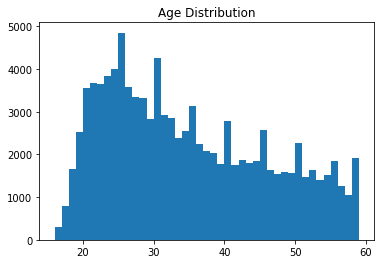

In [19]:
visualize.age_distribution_plot(df2015)

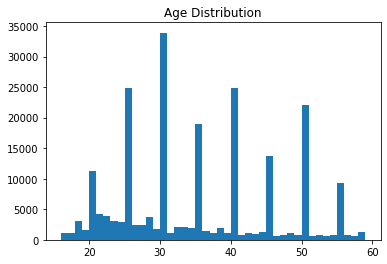

In [21]:
visualize.age_distribution_plot(df2018_2019)

Another example of some precision issues appears in the distribution of the ages. As you can see, there are higher than expected spikes at the 5 and 10 year increments, especially in the new datasets which use perceived age instead of actual age, which seems to imply some natural rounding done by the officers filling out the cards. However, seeing as we are mostly interested in race within this analysis, we will leave this alone so as to focus on the more important work.

## Data Cleaning

After exploring our data in depth, I was then able to make more informed decisions when cleaning the data, the result of which is shown below.

In [27]:
cleaned_df2015 = cleaning.clean_2014_2017('../data/raw/2015.csv', notebook = True)
cleaned_df2015.head()

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,1191287,Moving Violation,430,White,Female,NaN,2015-01-01,NaN,N,N,NaN,N,N
1,1191295,Moving Violation,520,Black/African American,Male,NaN,2015-01-01,NaN,N,N,NaN,N,N
2,1191275,Moving Violation,430,Black/African American,Male,NaN,2015-01-01,NaN,N,N,NaN,N,N
3,1191308,Moving Violation,520,White,Male,NaN,2015-01-01,NaN,N,N,NaN,N,N
4,1191285,Moving Violation,430,White,Female,NaN,2015-01-01,NaN,N,N,NaN,N,N


In [31]:
cleaned_df2018_2019 = cleaning.clean_2018_2019('../data/raw/2018-2019.csv', notebook = True)
cleaned_df2018_2019.head()

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,2443,Reasonable Suspicion,120,White,Male,25,2018-07-01,00:01:37,Y,N,NaN,N,N
1,2444,Traffic Violation,120,White,Male,25,2018-07-01,00:03:34,N,N,NaN,N,N
2,2447,Reasonable Suspicion,820,Hispanic/Latino/a,Male,30,2018-07-01,00:05:43,N,N,NaN,N,N
3,2448,Traffic Violation,610,White,Male,23,2018-07-01,00:19:06,N,N,NaN,N,N
4,2449,Reasonable Suspicion,110,White,Male,25,2018-07-01,00:03:00,Y,Y,NaN,N,N


## Stop Rates

Now that the data has been edited into a more usable form, we can begin to try to answer some of our questions regarding different races and their treatment by police on the road.

An initial, and in some ways naïve, way to measure whether or not police are enforcing traffic laws fairly is by comparing stop rates from race to race, and this is as good as any a place to start. By comparing the counts of the races who were stopped with the number of people of that race actually in that area (computed from the 2010 census data), we can begin to see whether or not the proportions of people stopped are equal amongst populations.

**Note**: There were no hispanics recorded in the census data that we found, and so we were forced to not include them in the following calculations, as there was no reasonable way to compute a denominator for the calculation.

In [28]:
census = pd.read_csv('../data/census.csv')
cleaned_census = cleaning.clean_census(census)

In [29]:
total_stop_rates = calculations.calc_total_stop_rates(cleaned_census, cleaned_df2015)
total_stop_rates

Asian                     0.042507
Black/African American    0.140957
Native American           0.076663
Pacific Islander          0.040961
White                     0.064783
dtype: float64

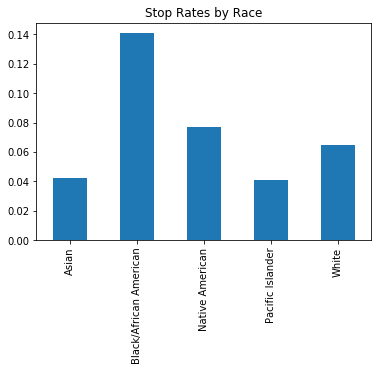

In [30]:
total_stop_rates_plot = total_stop_rates.plot(kind = 'bar')
title_1 = plt.title('Stop Rates by Race')

In [31]:
stop_rate_serv = calculations.calc_stop_rates_by_service_area(cleaned_census, cleaned_df2015)
stop_rate_serv

subject_race,White,Black/African American,Native American,Asian,Pacific Islander
service_area,,,,,
110,0.057212,0.142667,0.054983,0.025812,0.034483
120,0.101957,0.557182,0.068182,0.057631,0.096774
230,0.052505,0.134466,0.236364,0.032083,0.032154
240,0.060607,0.133475,0.386635,0.041999,0.027027
310,0.101898,0.183615,0.038462,0.119284,0.079914
320,0.044870,0.152244,0.029484,0.047897,0.032787
430,0.016809,0.064584,0.011004,0.012748,0.013610
440,0.023558,0.127516,0.036675,0.042881,0.019774
510,0.030027,0.104499,0.011885,0.064706,0.042105


It seems pretty evident that based on populations in the area, black drivers are being pulled over with a lot more regularity than white drivers city wide, with differing levels of discrimination present from service area to service area.

## Post-Stop Outcomes

Another way in which treatment disparity amongst races can be quanitifed is in how different races are treated once they've already been stopped.

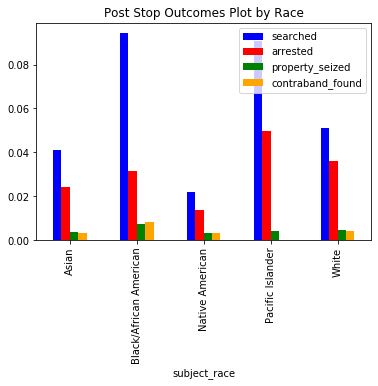

In [321]:
visualize.post_stop_plot(cleaned_df2015)

As is evident in the graph above, White, Asian, and Native American drivers are searched far less than Black and Pacific Islander drivers, while Pacific Islanders are arrested far more than any other demographic.

## Veil of Darkness

All of these analyses ultimately comes to a head with the Veil of Darkness technique as initially used by the SDSU study. In this study, their hypothesis is that cops can only make racially biased decisions when pulling over drivers if they can see the driver, i.e. when it's light outside. Therefore, a truly 'neutral' set of stop rates is when it's dark outside. By selecting only datapoints which fall in the inner-twilight period (which they define as 5:09 p.m. to 8:29 p.m.) they attempted to control for time while still getting a sampling of light and dark stops. 

The idea concludes with this: based on this technique, if the different races are stopped at the same rate in the day time as they are in the night time (i.e. when they can't be identified by their race), then police stops aren't being affected by racial prejudices. Below, I reconducted this test, and then conducted a Kolmogorov-Smirnov test in order to compare the two distributions that I calculated.

In [41]:
twilight_df = calculations.get_inner_twilight_period(cleaned_df2015)
twilight_df.head()

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized,is_in_twilight
0,1189877,Moving Violation,310,Asian,Male,29.0,2015-01-01,2020-03-17 17:20:00,N,N,NaN,N,N,True
1,1189878,Moving Violation,720,Black/African American,Male,24.0,2015-01-01,2020-03-17 17:23:00,N,N,NaN,N,N,True
2,1189879,Equipment Violation,230,White,Male,16.0,2015-01-01,2020-03-17 17:25:00,N,N,NaN,N,N,True
3,1189880,Equipment Violation,230,Hispanic/Latino/a,Male,47.0,2015-01-01,2020-03-17 17:26:00,N,N,NaN,N,N,True
4,1189884,Equipment Violation,820,Hispanic/Latino/a,Male,24.0,2015-01-01,2020-03-17 17:32:00,N,N,NaN,N,N,True


In [42]:
vod_df = calculations.veil_of_darkness(twilight_df, notebook = True)

In [253]:
dark_df = vod_df[vod_df['Dark']].reset_index(drop = True)
light_df = vod_df[~vod_df['Dark']].reset_index(drop = True)

In [254]:
dark_df.head()

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized,is_in_twilight,Month,Sunset,Dark
0,1189890,Equipment Violation,430,Black/African American,Female,50.0,2015-01-01,2020-03-16 18:20:00,N,N,NaN,N,N,True,1,2020-03-16 18:18:00,True
1,1189895,Equipment Violation,310,Hispanic/Latino/a,Female,28.0,2015-01-01,2020-03-16 18:20:00,N,Y,N,N,N,True,1,2020-03-16 18:18:00,True
2,1189896,Equipment Violation,430,Hispanic/Latino/a,Female,50.0,2015-01-01,2020-03-16 18:30:00,N,N,NaN,N,N,True,1,2020-03-16 18:18:00,True
3,1189892,Equipment Violation,620,White,Male,39.0,2015-01-01,2020-03-16 18:30:00,N,N,NaN,N,N,True,1,2020-03-16 18:18:00,True
4,1189893,Moving Violation,830,Asian,Male,18.0,2015-01-01,2020-03-16 18:35:00,N,N,NaN,N,N,True,1,2020-03-16 18:18:00,True


In [255]:
light_df.head()

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized,is_in_twilight,Month,Sunset,Dark
0,1189877,Moving Violation,310,Asian,Male,29.0,2015-01-01,2020-03-16 17:20:00,N,N,NaN,N,N,True,1,2020-03-16 18:18:00,False
1,1189878,Moving Violation,720,Black/African American,Male,24.0,2015-01-01,2020-03-16 17:23:00,N,N,NaN,N,N,True,1,2020-03-16 18:18:00,False
2,1189879,Equipment Violation,230,White,Male,16.0,2015-01-01,2020-03-16 17:25:00,N,N,NaN,N,N,True,1,2020-03-16 18:18:00,False
3,1189880,Equipment Violation,230,Hispanic/Latino/a,Male,47.0,2015-01-01,2020-03-16 17:26:00,N,N,NaN,N,N,True,1,2020-03-16 18:18:00,False
4,1189884,Equipment Violation,820,Hispanic/Latino/a,Male,24.0,2015-01-01,2020-03-16 17:32:00,N,N,NaN,N,N,True,1,2020-03-16 18:18:00,False


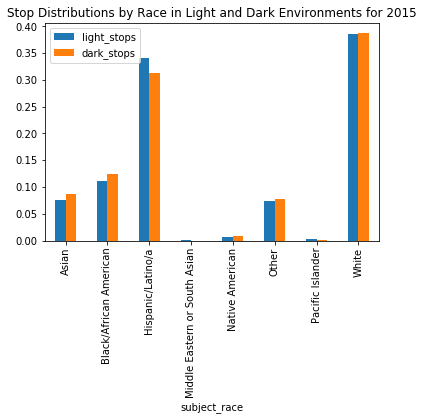

In [256]:
visualize.plot_light_dark(light_df, dark_df, 2015)

In [273]:
calculations.calc_ks(light_df, dark_df)

Ks_2sampResult(statistic=0.25, pvalue=0.98010878010878)

It seems fairly evident by the graph of these stop rates that the difference in these two distributions is negligible, which the KS Test statistics agree with, as the very high pvalue (.9801) indicates that there is very little difference between them. Both of these facts lead me to conclude that, according to the theory behind the Veil of Darkness, San Diego police officers don't act on racial prejudices when pulling over drivers.

There are some short comings to the Veil of Darkness, however, that should be addressed before taking this conclusion as gospel. The first of these is that it does not account for artificial light: just because it is dark outside doesn't necessarily mean that the officer couldn't identify the driver. Depending on the lighting on the street, how bright the moon was that night, and other factors, it's very possible that an officer could still differentiate race, at least on the most basic of levels.

The second issue is that, while this may indicate that the SDPD doesn't operate on prejudices when stopping drivers, it certainly does not mean that those prejudices don't exist and aren't acted upon at other times: an important distinction that may become lost in the initial conclusion. This is evidenced in our post-stop outcomes calculations from before: certain minorities (black drivers especially) were treated with far more harshness than their white counterparts, an important thing to remember before one attempts to use the Veil of Darkness to disregard claims of racial bias.

## Beyond the SDSU Study and Conclusion

Moving beyond the initial SDSU study, which only calculated these statistics for 2015, I wanted to dig deeper and see if anything changed with regards to these numbers in the following years (2016 and 2017), thinking that perhaps the growing hostility surrounding politics may have had an effect on these statistics.

In [173]:
df2016 = pd.read_csv('../data/raw/2016.csv')
df2017 = pd.read_csv('../data/raw/2017.csv')

In [174]:
cleaned_df2016 = cleaning.clean_2014_2017(df2016)
cleaned_df2017 = cleaning.clean_2014_2017(df2017)

In [176]:
twilight_df_2016 = calculations.get_inner_twilight_period(cleaned_df2016)
twilight_df_2017 = calculations.get_inner_twilight_period(cleaned_df2017)

In [178]:
vod_df_2016 = calculations.veil_of_darkness(twilight_df_2016, notebook = True)
vod_df_2017 = calculations.veil_of_darkness(twilight_df_2017, notebook = True)

In [180]:
dark_df_2016 = vod_df_2016[vod_df_2016['Dark']].reset_index(drop = True)
dark_df_2017 = vod_df_2017[vod_df_2017['Dark']].reset_index(drop = True)

In [181]:
light_df_2016 = vod_df_2016[~vod_df_2016['Dark']].reset_index(drop = True)
light_df_2017 = vod_df_2017[~vod_df_2017['Dark']].reset_index(drop = True)

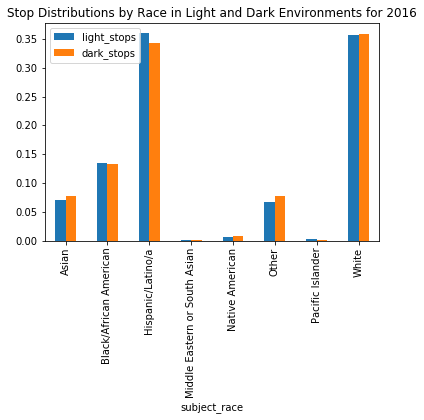

In [282]:
visualize.plot_light_dark(light_df_2016, dark_df_2016, 2016)

In [274]:
calculations.calc_ks(light_df_2016, dark_df_2016)

Ks_2sampResult(statistic=0.25, pvalue=0.98010878010878)

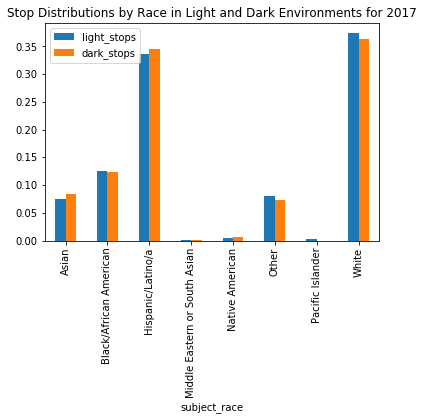

In [227]:
visualize.plot_light_dark(light_df_2017, dark_df_2017, 2017)

In [279]:
calculations.calc_ks(light_df_2017, dark_df_2017)

Ks_2sampResult(statistic=0.125, pvalue=1.0)

It turned out however, that the stop rates maintained their consistency from light to dark, indicating that the change in political climate had no difference in the behavior of police while stopping drivers. Ultimately, the Veil of Darkness is a very good tool for determining when stop rates are biased, and can yield very informative results, but it is important to keep those results in context when attempting to draw conclusions about race in America.